# Normalizing flows

In [1]:
# Import required packages
import os
import torch
import torchvision as tv
import numpy as np
import normflows as nf
import logging
import random

from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import Image
from torchvision import datasets

In [2]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [3]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'Set seed {seed}')

set_seed(42)  # Use any number you like here

Set seed 42


In this notebook we will use Normalizing Flows as a generative model for the MNIST dataset. We will use the [normflows](https://github.com/VincentStimper/normalizing-flows/tree/36b58d34333aa301a5f42f327590ca72373a35eb) Python package. Specifically, we will use the [Glow](https://arxiv.org/pdf/1807.03039.pdf) normalizing flow. This notebook is adapted from [this notebook](https://github.com/VincentStimper/normalizing-flows/blob/36b58d34333aa301a5f42f327590ca72373a35eb/examples/glow.ipynb). Let's get started!

## Minimizing the likelihood with Normalizing Flows

Normalizing flows transform a target distribution to a pre-defined simpler distribution through a sequence of **flows**, which are invertible operations. These sequence of flows allows for the evaluation of the complex distribution by evaluating the simple distribution by accounting for the flow, as shown by the following formula:

$$ 
    p_X(x) = p_Z(f(x))\vert \det Df(x)\vert
$$

We can now minimize the log-likelihood of the complex distribution as follows:

$$
    -\log p_X(x) = - \log p_Z(f(x)) - \log(\vert \det Df(x)\vert).
$$

To make a neural network invertible while retaining its ability to model distribution and making the inversion computationally feasible, flows typically constitute of splitting operations as shown below.

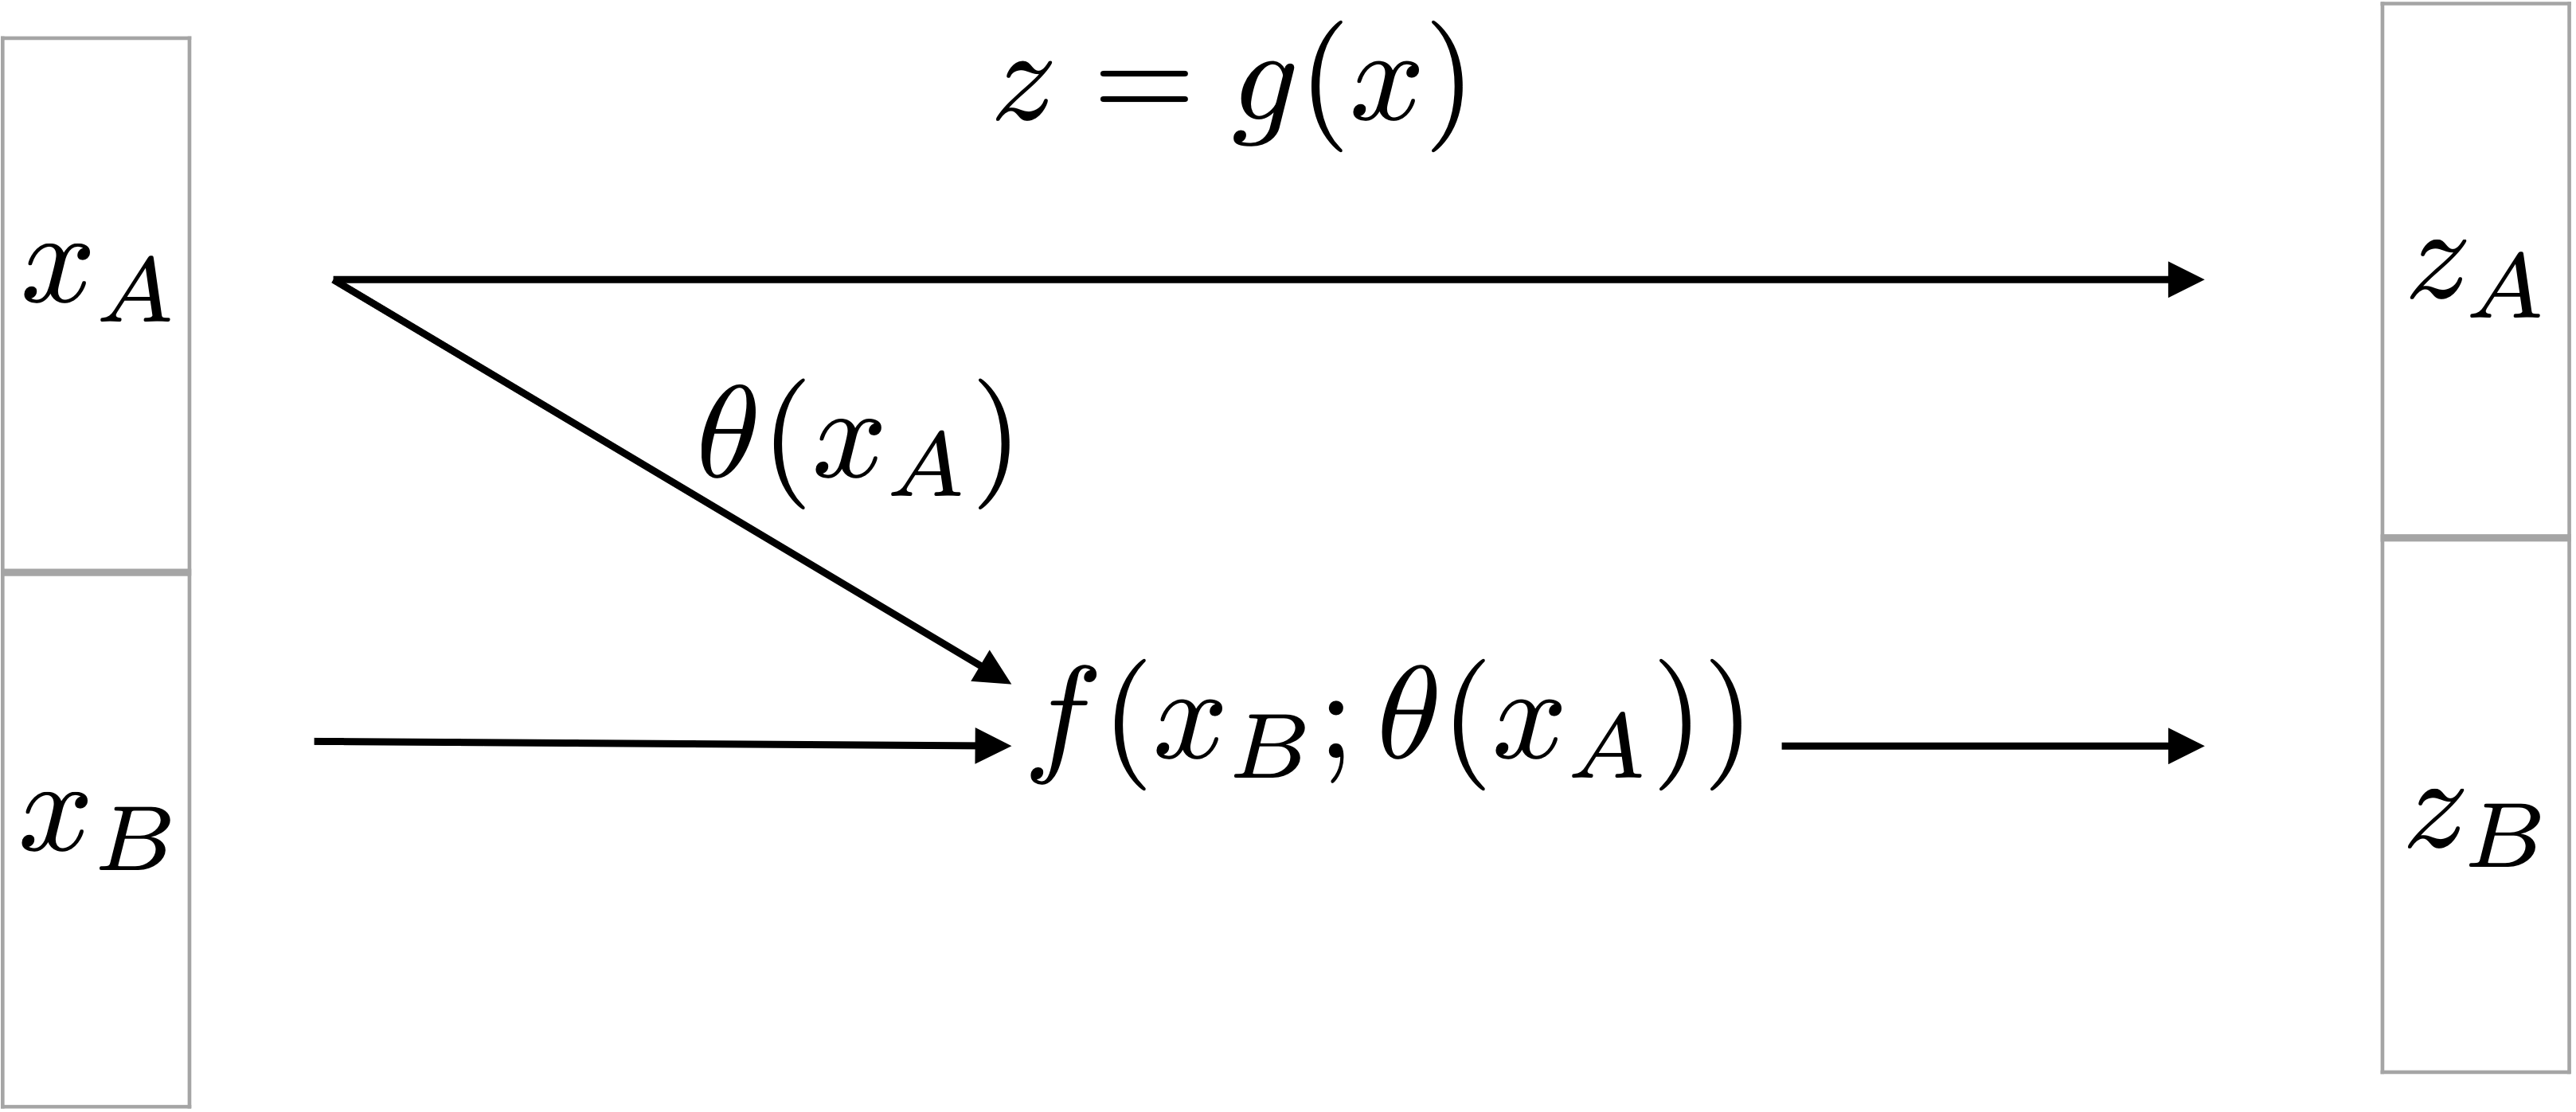

In [4]:
Image(filename='Figures/coupling_flow.png',width=900, height=400)

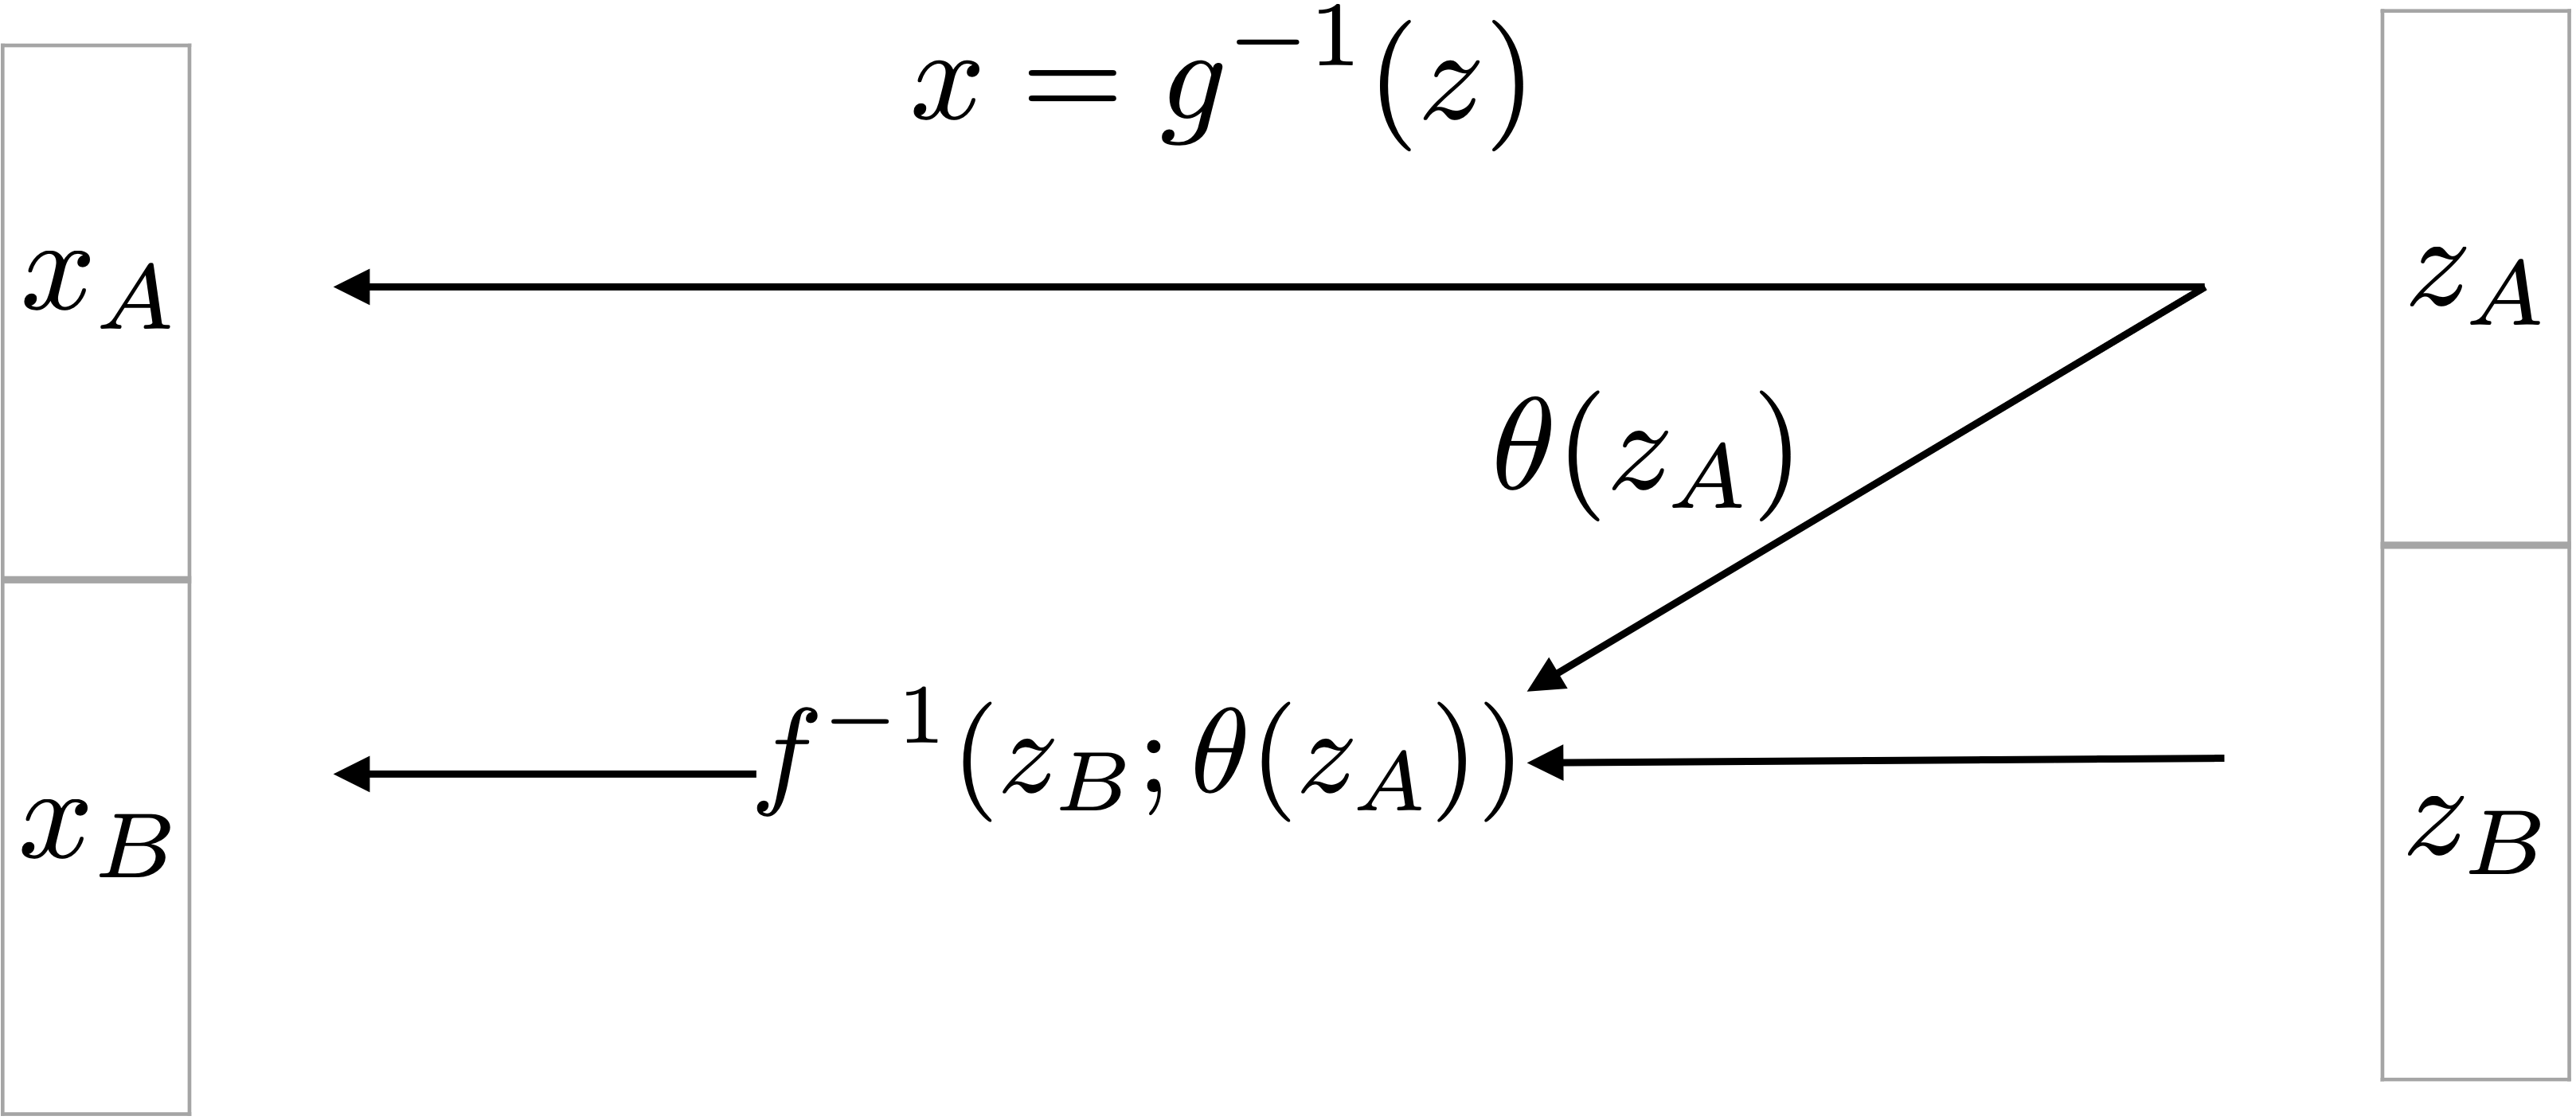

In [5]:
Image(filename='Figures/coupling_flow_inv.png',width=900, height=400)

## Constructing a flow using the normflows package

The following code blocks are embedded into the normflows library and here we go over the inner workings together. The Glow architecture looks as follows ([source](https://arxiv.org/pdf/1807.03039.pdf)).

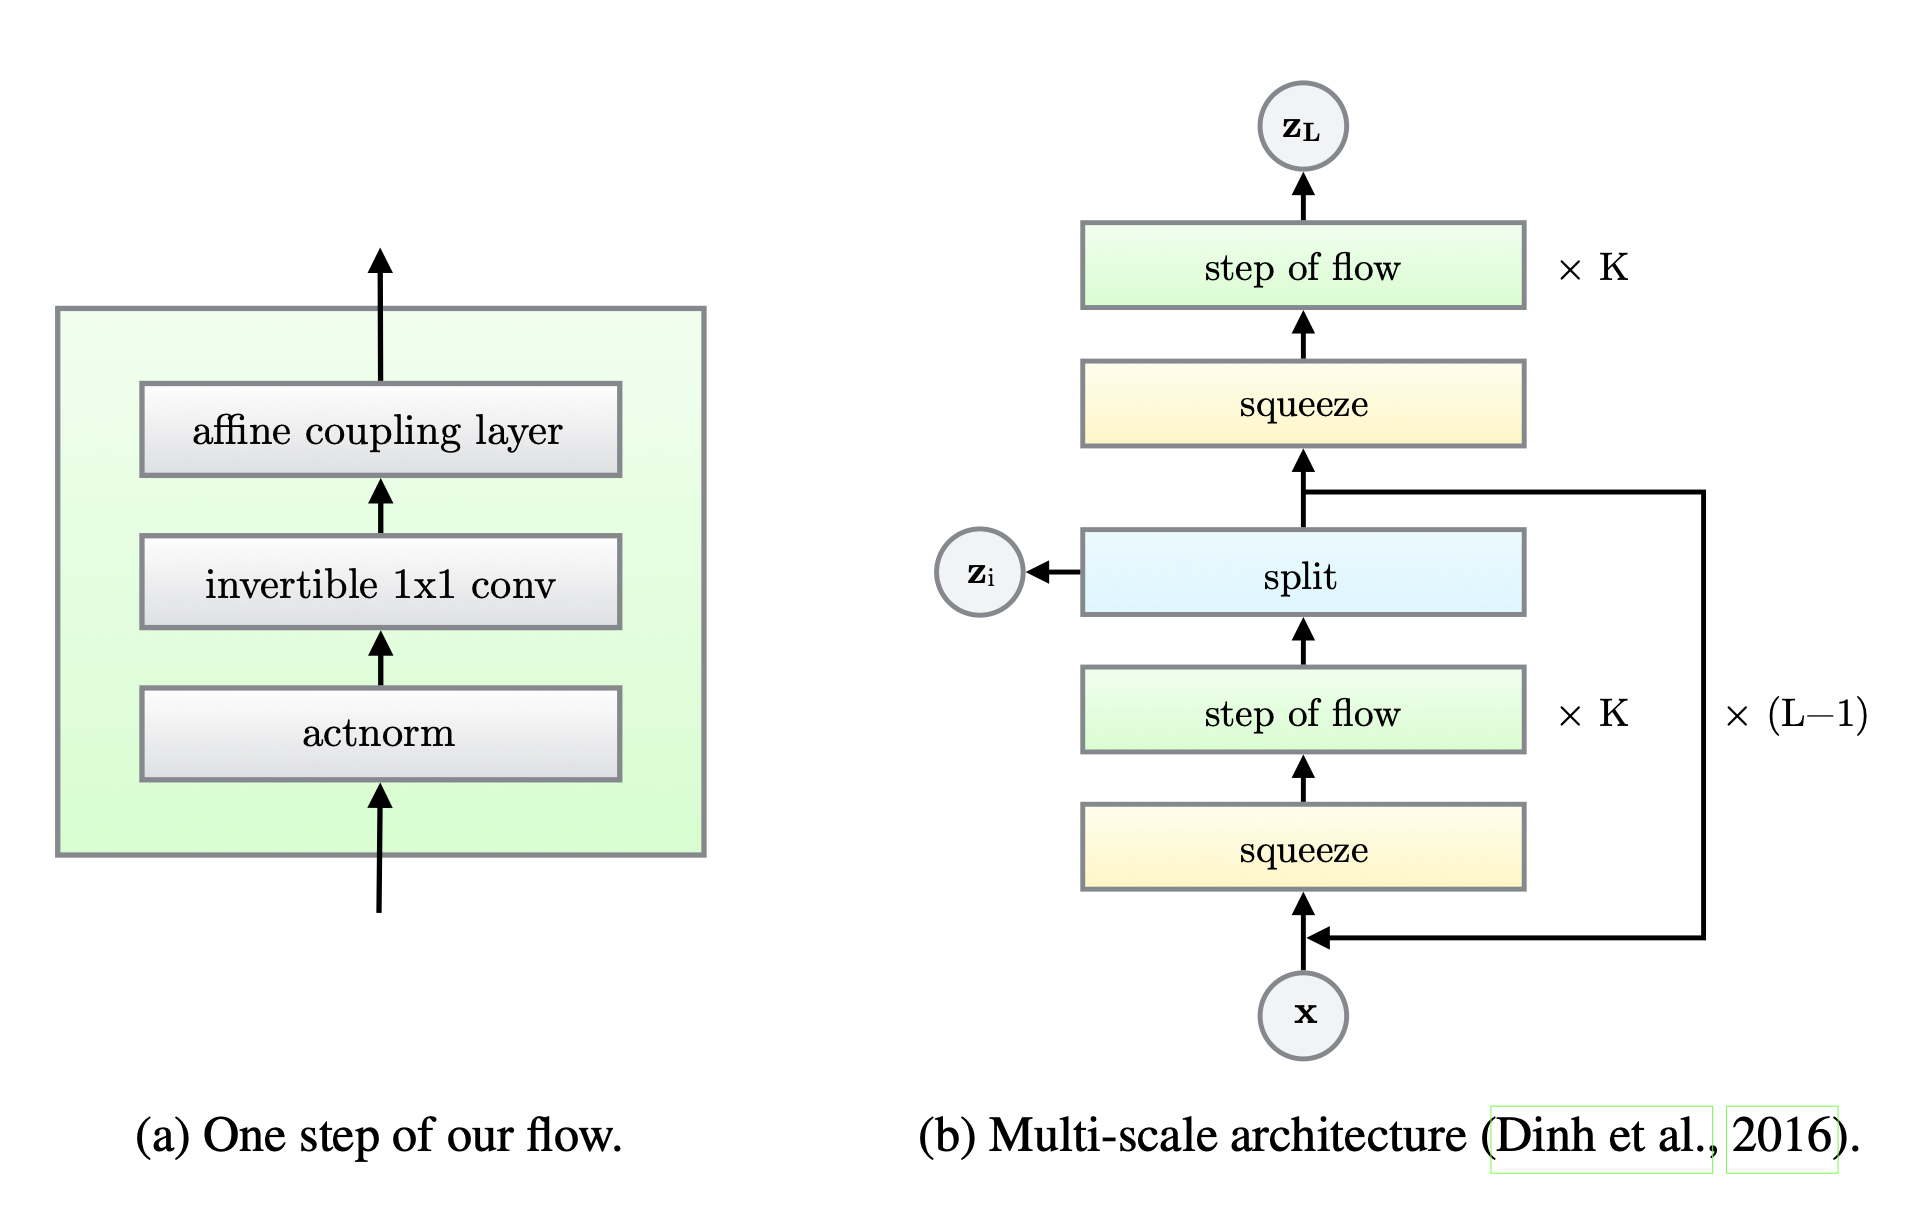

In [6]:
Image(filename='Figures/multi-scale.png',width=900, height=400)

We start by constructing the coupling function. Do not run the below cells as they will give an error! All the below functions are directly from the normflows package and that's where we load them from later.

```
class AffineCoupling(Flow):
    """
    Affine Coupling layer as introduced RealNVP paper, see arXiv: 1605.08803
    """

    def __init__(self, param_map, scale=True, scale_map="exp"):
        """Constructor

        Args:
          param_map: Maps features to shift and scale parameter (if applicable)
          scale: Flag whether scale shall be applied
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow, 'sigmoid_inv' uses multiplicative sigmoid scale when sampling from the model
        """
        super().__init__()
        self.add_module("param_map", param_map)
        self.scale = scale
        self.scale_map = scale_map

    def forward(self, z):
        """
        z is a list of z1 and z2; ```z = [z1, z2]```
        z1 is left constant and affine map is applied to z2 with parameters depending
        on z1

        Args:
          z
        """
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == "exp":
                z2 = z2 * torch.exp(scale_) + shift
                log_det = torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid":
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 / scale + shift
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid_inv":
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 * scale + shift
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError("This scale map is not implemented.")
        else:
            z2 = z2 + param
            log_det = zero_log_det_like_z(z2)
        return [z1, z2], log_det

    def inverse(self, z):
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == "exp":
                z2 = (z2 - shift) * torch.exp(-scale_)
                log_det = -torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid":
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) * scale
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid_inv":
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) / scale
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError("This scale map is not implemented.")
        else:
            z2 = z2 - param
            log_det = zero_log_det_like_z(z2)
        return [z1, z2], log_det

Next, we include the splitting and merging operations into the network that define the multi-scale architecture. 

```
class AffineCouplingBlock(Flow):
    """
    Affine Coupling layer including split and merge operation
    """

    def __init__(self, param_map, scale=True, scale_map="exp", split_mode="channel"):
        """Constructor

        Args:
          param_map: Maps features to shift and scale parameter (if applicable)
          scale: Flag whether scale shall be applied
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow
          split_mode: Splitting mode, for possible values see Split class
        """
        super().__init__()
        self.flows = nn.ModuleList([])
        # Split layer
        self.flows += [Split(split_mode)]
        # Affine coupling layer
        self.flows += [AffineCoupling(param_map, scale, scale_map)]
        # Merge layer
        self.flows += [Merge(split_mode)]

    def forward(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_tot += log_det
        return z, log_det_tot

    def inverse(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_tot += log_det
        return z, log_det_tot

And now we are ready to build one Glow block.

```
class GlowBlock(Flow):
    """Glow: Generative Flow with Invertible 1×1 Convolutions, [arXiv: 1807.03039](https://arxiv.org/abs/1807.03039)

    One Block of the Glow model, comprised of

    - MaskedAffineFlow (affine coupling layer)
    - Invertible1x1Conv (dropped if there is only one channel)
    - ActNorm (first batch used for initialization)
    """

    def __init__(
        self,
        channels,
        hidden_channels,
        scale=True,
        scale_map="sigmoid",
        split_mode="channel",
        leaky=0.0,
        init_zeros=True,
        use_lu=True,
        net_actnorm=False,
    ):
        """Constructor

        Args:
          channels: Number of channels of the data
          hidden_channels: number of channels in the hidden layer of the ConvNet
          scale: Flag, whether to include scale in affine coupling layer
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow
          split_mode: Splitting mode, for possible values see Split class
          leaky: Leaky parameter of LeakyReLUs of ConvNet2d
          init_zeros: Flag whether to initialize last conv layer with zeros
          use_lu: Flag whether to parametrize weights through the LU decomposition in invertible 1x1 convolution layers
          logscale_factor: Factor which can be used to control the scale of the log scale factor, see [source](https://github.com/openai/glow)
        """
        super().__init__()
        self.flows = nn.ModuleList([])
        # Coupling layer
        kernel_size = (3, 1, 3)
        num_param = 2 if scale else 1
        if "channel" == split_mode:
            channels_ = ((channels + 1) // 2,) + 2 * (hidden_channels,)
            channels_ += (num_param * (channels // 2),)
        elif "channel_inv" == split_mode:
            channels_ = (channels // 2,) + 2 * (hidden_channels,)
            channels_ += (num_param * ((channels + 1) // 2),)
        elif "checkerboard" in split_mode:
            channels_ = (channels,) + 2 * (hidden_channels,)
            channels_ += (num_param * channels,)
        else:
            raise NotImplementedError("Mode " + split_mode + " is not implemented.")
        param_map = nets.ConvNet2d(
            channels_, kernel_size, leaky, init_zeros, actnorm=net_actnorm
        )
        self.flows += [AffineCouplingBlock(param_map, scale, scale_map, split_mode)]
        # Invertible 1x1 convolution
        if channels > 1:
            self.flows += [Invertible1x1Conv(channels, use_lu)]
        # Activation normalization
        self.flows += [ActNorm((channels,) + (1, 1))]

    def forward(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_tot += log_det
        return z, log_det_tot

    def inverse(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_tot += log_det
        return z, log_det_tot

Finally, we are ready to construct the Glow architecture!

In [7]:
img_size = 32
mnist_channels = 1

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (mnist_channels, img_size, img_size)
n_dims = np.prod(input_shape)
channels = mnist_channels
hidden_channels = 256
split_mode = 'channel'
scale = True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]

# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)
model = model.to(device)

/home/ali/.virtualenvs/PyTorch/lib/python3.10/site-packages/torch/_tensor.py:795: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(


In [8]:
try:
    # Load the model state_dict
    model.load_state_dict(torch.load('model.pth'))
    print("Model loaded")
except FileNotFoundError:
    print('Model was not found.')

Model was not found.


Let's load the MNIST dataset

In [9]:
img_size = 32
batch_size = 512

# Create a directory to store the MNIST dataset.
# 'exist_ok=True' makes sure the command does not fail if the directory already exists.
os.makedirs("../mnist/data", exist_ok=True)

# Create a DataLoader to handle batching of the MNIST dataset.
dataloader = torch.utils.data.DataLoader(
    
    # Load the MNIST dataset from PyTorch's built-in datasets.
    datasets.MNIST(
        # Set the directory where the data is stored or where it will be downloaded.
        "../mnist/data",
        # Use the training portion of the dataset.
        train=True,
        # Download the dataset if it is not already in the specified directory.
        download=True,
        # Apply several transformations to the images in the dataset:
        transform=transforms.Compose(
            [
                # Resize images to the size specified by the 'img_size' variable.
                transforms.Resize(img_size),
                # Convert images from PIL format to PyTorch tensors.
                transforms.ToTensor(),
                # Normalize tensors so that the pixel intensity values have a mean of 0.5 and a standard deviation of 0.5.
                transforms.Normalize([0.5], [0.5])
            ]
        ),
    ),

    # Set the number of samples per batch to load.
    batch_size=batch_size,
    # Enable shuffling to feed data points in a random manner.
    shuffle=True,
)

train_iter = iter(dataloader)

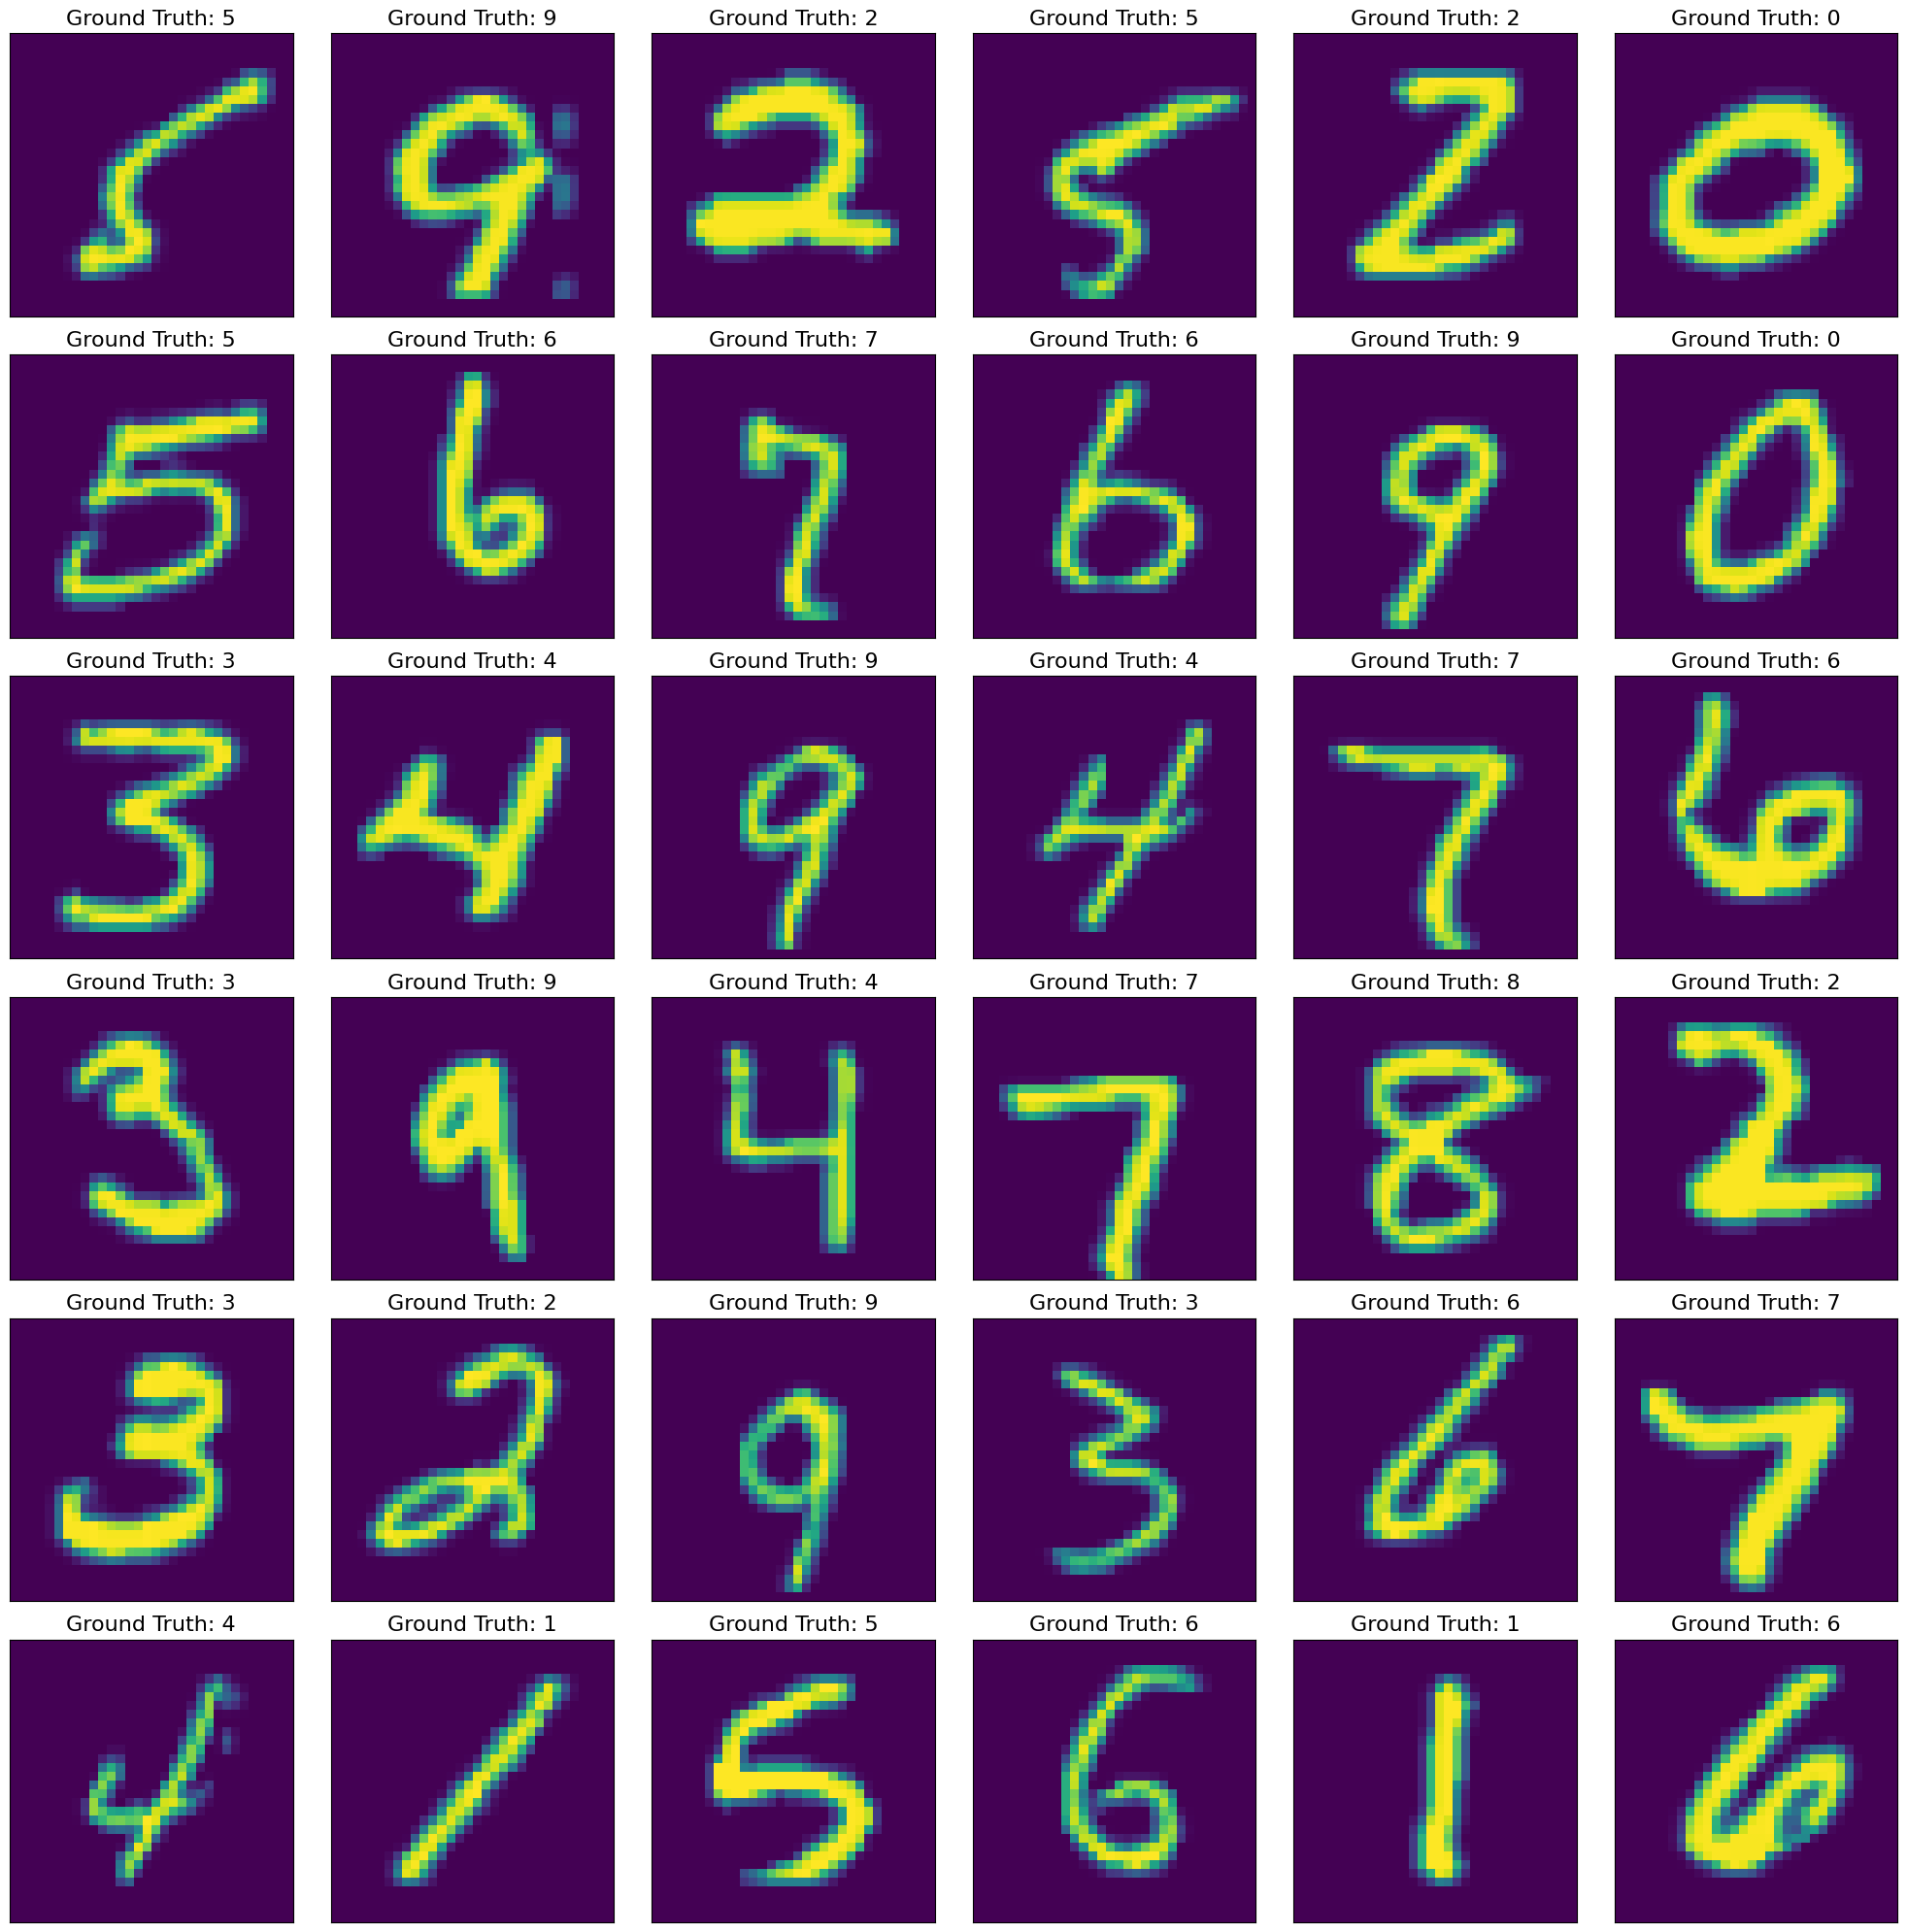

In [10]:
examples = enumerate(dataloader)
batch_idx, (example_data, example_targets) = next(examples)

# There is some annoying warning regarding clipping because of the scaling of the data and this ignores is
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

fig = plt.figure(figsize=(20,20))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i].permute(1, 2, 0)), interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]), fontsize=16)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

logger.setLevel(old_level)

In [11]:
epochs = 200

loss_hist = np.array([])
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(epochs)):
    loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        ls = model.forward_kld(x.to(device), y.to(device))
        if ~(torch.isnan(ls) | torch.isinf(ls)):
            ls.backward()
            optimizer.step()
        loss += ls.item()
        
    loss_hist = np.append(loss_hist, loss)

100%|██████████| 200/200 [2:22:42<00:00, 42.81s/it]  


In [12]:
# Save the model state_dict
torch.save(model.state_dict(), 'model.pth')

/home/ali/.virtualenvs/PyTorch/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


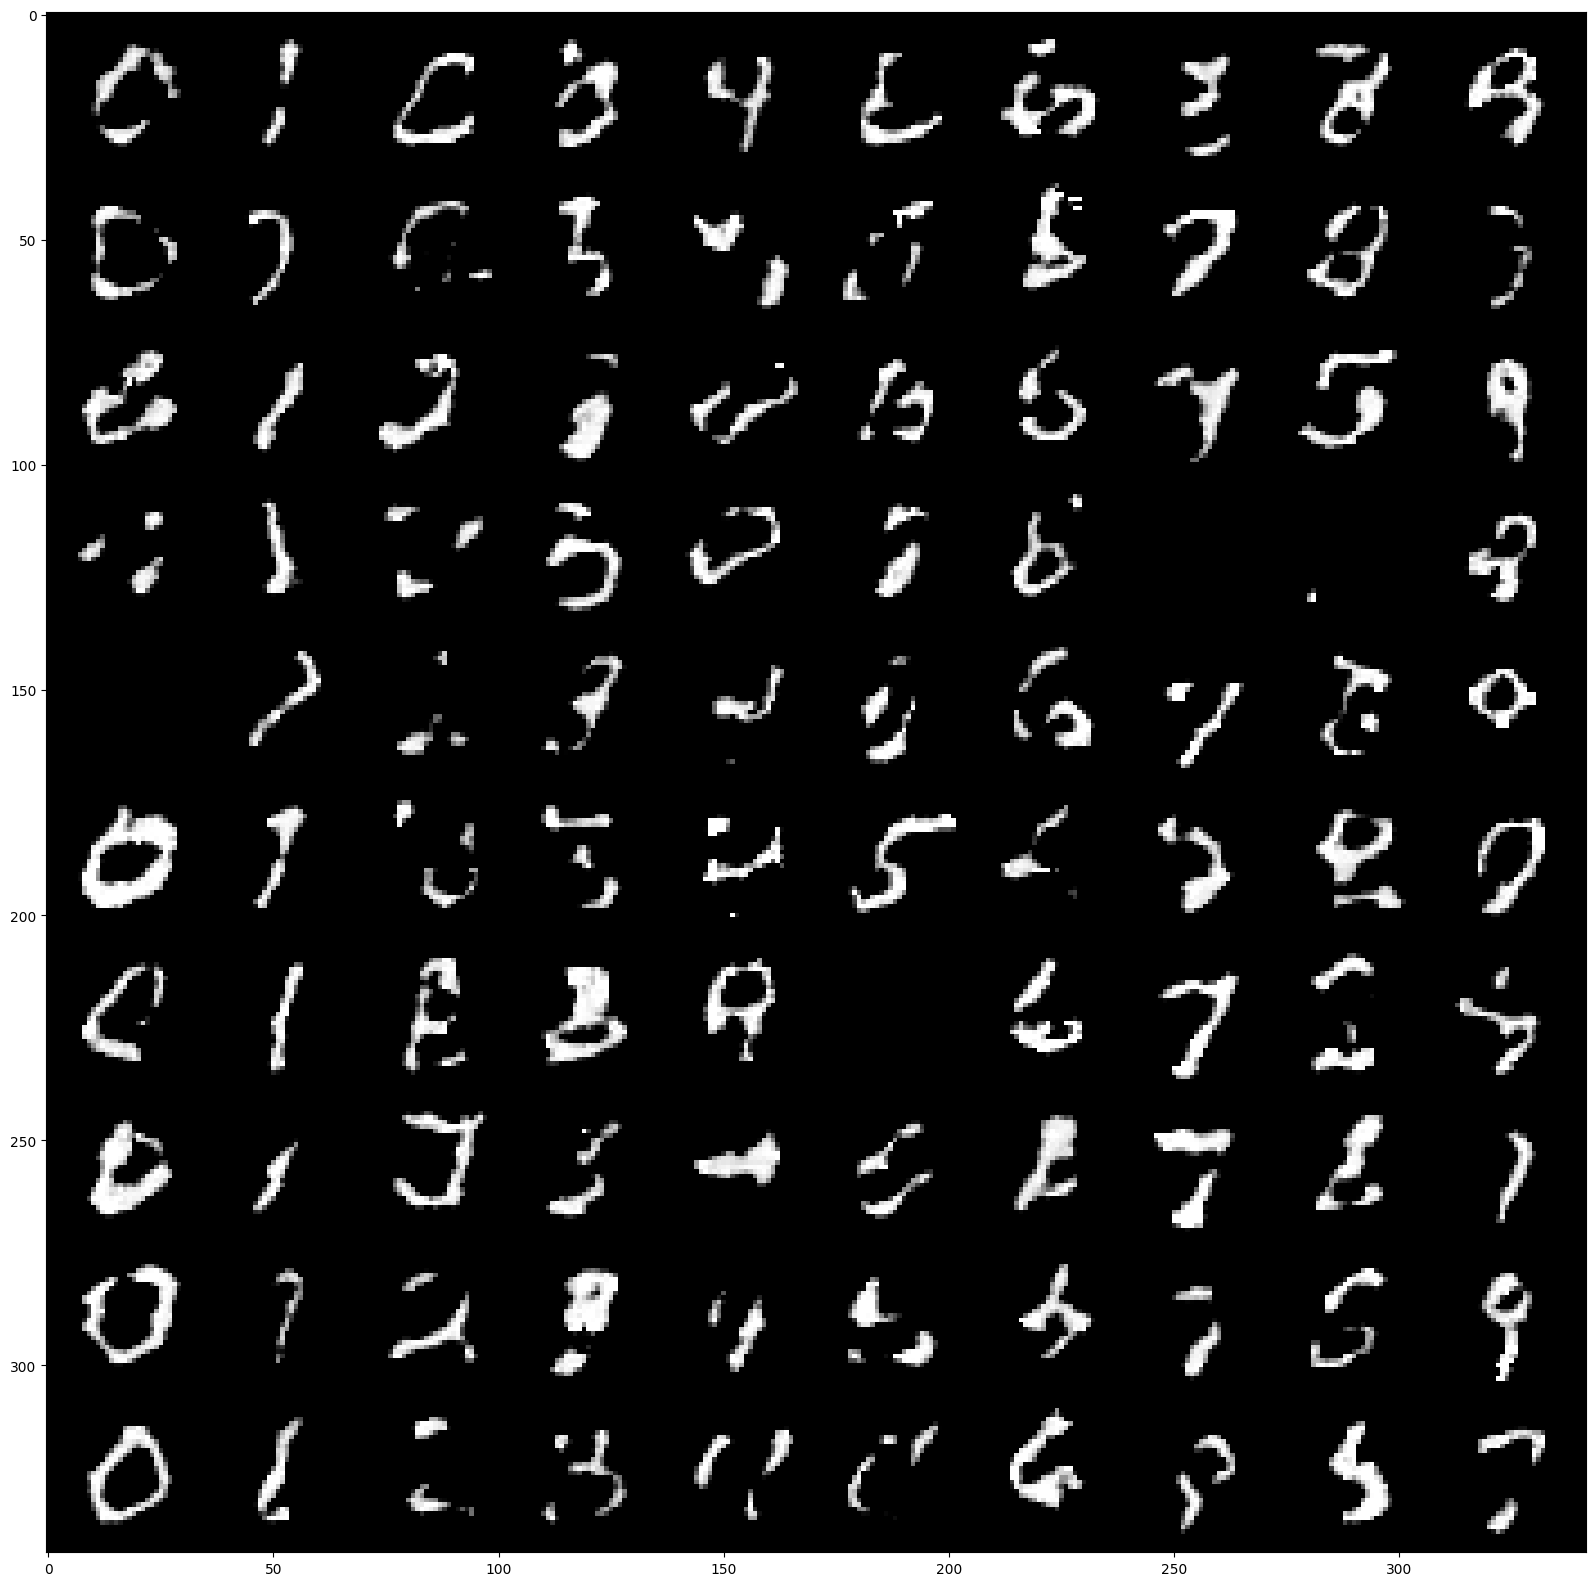

In [13]:
# Model samples
num_sample = 10

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [14]:
# Get bits per dim
n = 0
bpd_cum = 0
with torch.no_grad():
    for x, y in iter(dataloader):
        nll = model(x.to(device), y.to(device))
        nll_np = nll.cpu().numpy() 
        bpd_cum += np.nansum(nll_np / np.log(2) / n_dims + 8)
        n += len(x) - np.sum(np.isnan(nll_np))
        
    print('Bits per dim: ', bpd_cum / n)

Bits per dim:  -2.2227395665486656


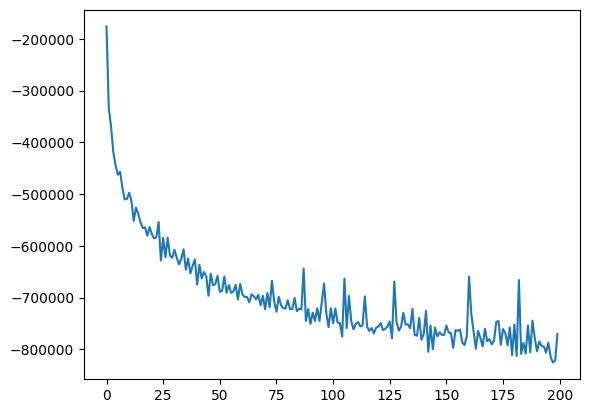

In [15]:
plt.plot(loss_hist)